# Algorithm
1. initialize k = some constant, `k`: **no. of clusters** the points will be clustered in
2. select k random points from the sample: `cluster_centroids`.
3. for each point of the data set
    1. find distance with all points in `cluster_centroids`
    2. assign point to the closest cluster_centroid
4. recalculate `cluster_centroids` using mean of all points of each cluster
5. convergence
    1. `cluster_centroids` remain same
    2. cluster no. of no point changes

In [4]:
from typing import List

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

from scipy.interpolate import UnivariateSpline
import scipy.signal as scipy_signal

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import numpy as np, math

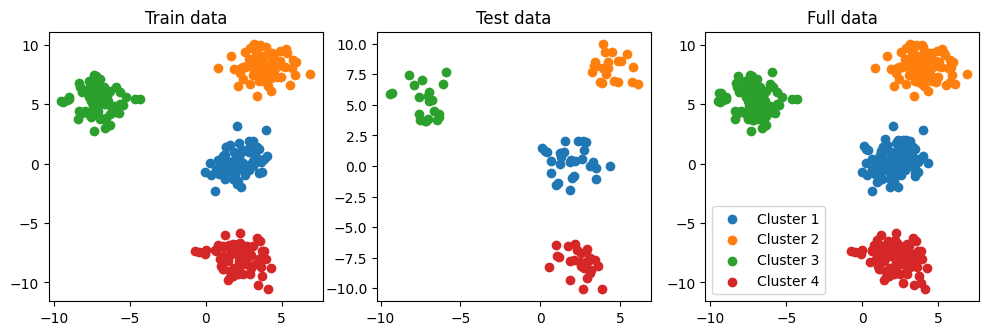

In [64]:
# 2-d clusters 
X, y = make_blobs(n_samples=400, centers=4)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42
)

fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
for cluster_index in (list(set(y))):
    ax[0].scatter(X_train[y_train == cluster_index, 0], X_train[y_train == cluster_index, 1], label=f'Cluster {cluster_index+1}')
    ax[0].set_title('Train data')

    ax[1].scatter(X_test[y_test == cluster_index, 0], X_test[y_test == cluster_index, 1], label=f'Cluster {cluster_index+1}')
    ax[1].set_title('Test data')

    ax[2].scatter(X[y == cluster_index, 0], X[y == cluster_index, 1], label=f'Cluster {cluster_index+1}')
    ax[2].set_title('Full data')
plt.legend()
plt.show()

In [104]:
class myKmeans:
    def __init__(self, n_clusters: int, seed = 42):
        self.n_clusters = n_clusters
        self.cluster_centroids = None
        self.rng = np.random.default_rng(seed = seed) # random number generator

    def fit(
            self, 
            X: np.ndarray, 
            n_iter: int = 100, 
            track_distances: bool = False, 
            disable_pbar: bool = False,
            convergence_threshold: float = 0.01
        ):
        # cluster_centroids = X[np.random.randint(0, X.shape[0], size=self.n_clusters, random), :] # centroid initialisation
        cluster_centroids = X[self.rng.integers(0, X.shape[0], size=self.n_clusters), :] # centroid initialisation
        distance_track = []
        # final_clusters = None

        loop = range(n_iter)
        if not disable_pbar:
            loop = tqdm(range(n_iter), "Iterating through K-Means Clustering...")
        for itr_idx in loop:
            clusters = [[] for _ in range(self.n_clusters)]
            
            # assign each sample to a cluster
            for pt_idx in range(X.shape[0]):
                distances = []
                for c in cluster_centroids:
                    distances.append(np.linalg.norm((X[pt_idx, :] - c))) # euclidean distance of current sample from each cluster_centroid
                distances = np.array(distances)
                clusters[np.argmin(distances)].append(pt_idx)
            new_centroids = [
                np.mean(X[np.array(clusters[i]), :], axis=0) if clusters[i] else cluster_centroids[i]
                for i in range(len(clusters))
            ]

            # track distances to observe centroid variation
            curr_iteration_dist = [                                      
                np.linalg.norm(new_centroids[i] - cluster_centroids[i])
                for i in range(self.n_clusters)
            ]

            # Convergence
            if max(curr_iteration_dist) < convergence_threshold:
                self.cluster_centroids = new_centroids
                if track_distances:
                    distance_track.append(curr_iteration_dist)
                if not disable_pbar:
                    print(f"Reached convergence at iteration {itr_idx}, stopping KMeans...")
                break
            
            self.cluster_centroids = new_centroids
            cluster_centroids = new_centroids          # assign new centroids
            self.final_clusters = clusters             # store clusters into an outside-the-loop-scope variable
            if track_distances:                        # store the centroid-shift distances for this iteration
                distance_track.append(curr_iteration_dist) 

        if track_distances:
            return self.final_clusters, np.array(distance_track)
        return self.final_clusters
    
    def predict(self, X: np.ndarray, disable_pbar: bool = False):
        X_copy = X.copy()
        if X_copy.ndim == 1:
            X_copy = X_copy.reshape(1, X_copy.shape[0])
        predicted_clusters = [[] for _ in range(self.n_clusters)]
        n_samples_to_predict = X.shape[0]
        loop = range(n_samples_to_predict)
        if not disable_pbar:
            loop = tqdm(range(n_samples_to_predict), f"Predicting for {n_samples_to_predict} given points...")
        for pt_idx in loop:
            distances = []
            for c in self.cluster_centroids:
                distances.append(np.linalg.norm((X[pt_idx, :] - c))) # euclidean distance of current sample from each cluster_centroid
            predicted_clusters[np.argmin(np.array(distances))].append(pt_idx)
        return predicted_clusters


In [120]:
import numpy as np

# Assuming x is your N-dimensional array
# Example for a 4D array
x = np.random.rand(2, 3, 4, 5)  # Shape (3, 4, 5, 6)

# Compute the norm to get a shape of (3, 4)
norm_output = np.linalg.norm(x, axis=tuple(range(2, x.ndim)))

print("Shape of the norm output:", norm_output.shape)  # Should be (3, 4)

# if x.ndim > 4, the remaining dimensions need to be compressed till you have an x having ndim=4
# this is because the 


Shape of the norm output: (2, 3)


In [65]:
kmeans_clusterer = myKmeans(n_clusters=4)
final_clusters_train, distance_track = kmeans_clusterer.fit(X_train, track_distances=True)
final_clusters_test = kmeans_clusterer.predict(X_test)

Iterating through K-Means Clustering...:   0%|          | 0/100 [00:00<?, ?it/s]

Reached convergence at iteration 3, stopping KMeans...


Predicting for 100 given points...:   0%|          | 0/100 [00:00<?, ?it/s]

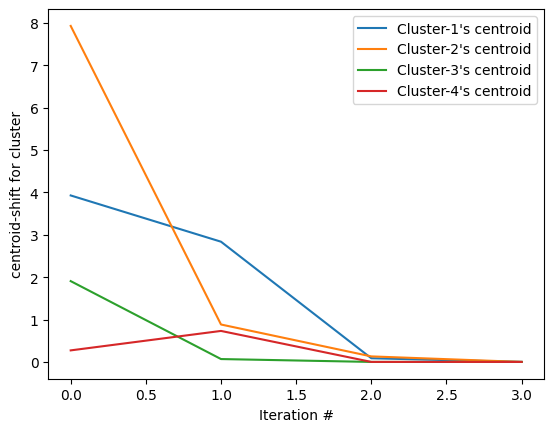

In [66]:
for centroid_index in range(kmeans_clusterer.n_clusters):
    plt.plot(range(distance_track.shape[0]), distance_track[:, centroid_index], label = f"Cluster-{centroid_index+1}'s centroid")

plt.xlabel('Iteration #')
plt.ylabel('centroid-shift for cluster')

plt.legend()
plt.show()

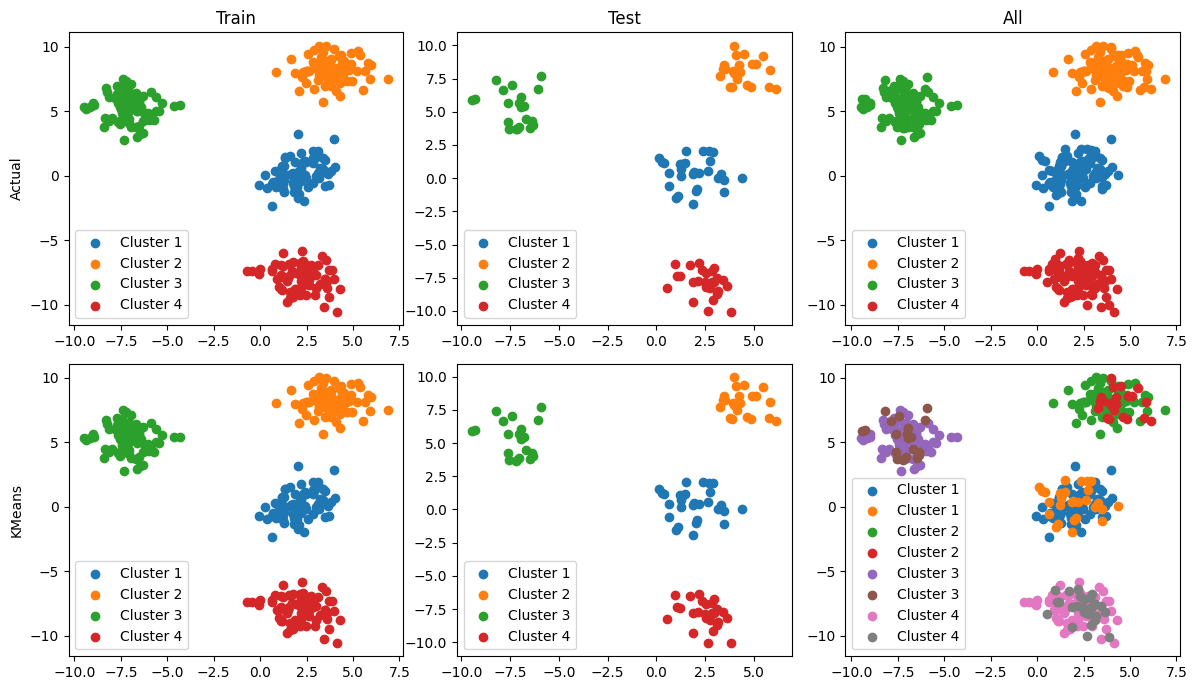

In [67]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7))

for cluster_index in (list(set(y))):
    ax[0][0].scatter(X_train[y_train == cluster_index, 0], X_train[y_train == cluster_index, 1], label=f'Cluster {cluster_index+1}')
    ax[0][1].scatter(X_test[y_test == cluster_index, 0], X_test[y_test == cluster_index, 1], label=f'Cluster {cluster_index+1}')
    ax[0][2].scatter(X[y == cluster_index, 0], X[y == cluster_index, 1], label=f'Cluster {cluster_index+1}')

for cluster_index in range(kmeans_clusterer.n_clusters):
    ax[1][0].scatter(X_train[final_clusters_train[cluster_index], 0], X_train[final_clusters_train[cluster_index], 1], label=f'Cluster {cluster_index+1}')
    ax[1][1].scatter(X_test[final_clusters_test[cluster_index], 0], X_test[final_clusters_test[cluster_index], 1], label=f'Cluster {cluster_index+1}')

    ax[1][2].scatter(X_train[final_clusters_train[cluster_index], 0], X_train[final_clusters_train[cluster_index], 1], label=f'Cluster {cluster_index+1}')
    ax[1][2].scatter(X_test[final_clusters_test[cluster_index], 0], X_test[final_clusters_test[cluster_index], 1], label=f'Cluster {cluster_index+1}')


for i in range(2):
    ax[i][0].set_ylabel(['Actual', 'KMeans'][i])
    for j in range(3):
        if i == 0:
            ax[i][j].set_title(['Train', 'Test', 'All'][j])
        ax[i][j].legend()

plt.tight_layout()
plt.show()

# Elbow-method to choose the optimal `k` value
1. from `n_clusters = 1` till `n_clusters = n_samples`, find WCSS: within-cluster sum of squared distances
    1. for a cluster, $WCSS_{c}$ = sum of distances of points in cluster c from centroid of this cluster.
    2. for a sample, WCSS = $\sum\limits_{c=1}^{n\_clusters}WCSS_c$.
2. the point where the curve flattens : elbow point, corresponding `n_clusters` should be used.
3. **Mathematical Intuition**
    1. for `n_clusters = n_samples`, WCSS = 0 as each sample will be its own cluster and its own centroid.
    2. hence, the curve will have a declining nature from `n_clusters = 1` to `n_clusters = n_samples`.

In [106]:
def elbow_curve(X: np.ndarray, n_clusters_arr: List[int] = None, seed = 42):
    wcss_arr = []
    n_samples = range(1, 1+X.shape[0])
    if n_clusters_arr:
        n_samples = n_clusters_arr
    for n_clusters in tqdm(n_samples, "Elbow-method..."):
        kmeans_clusterer = myKmeans(n_clusters=n_clusters, seed = seed)
        final_clusters_train = kmeans_clusterer.fit(X, disable_pbar=True)
        curr_wcss = 0
        for cluster_idx in range(n_clusters):
            if final_clusters_train[cluster_idx]: # check if the current cluster is empty
                for pt_idx in final_clusters_train[cluster_idx]:
                    curr_wcss += np.linalg.norm(X[pt_idx, :] - kmeans_clusterer.cluster_centroids[cluster_idx])**2
                kmeans_clusterer.cluster_centroids[cluster_idx]
        wcss_arr.append(curr_wcss)
    return wcss_arr

Elbow-method...:   0%|          | 0/16 [00:00<?, ?it/s]

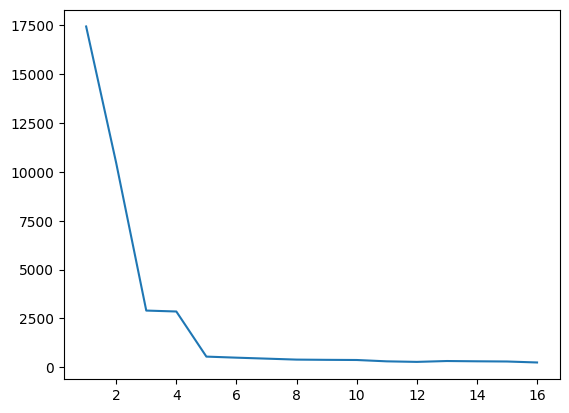

In [69]:
n_clusters_arr = list(range(1, int(math.sqrt(X_train.shape[0]))))
wcss_arr = elbow_curve(X_train, n_clusters_arr)
plt.plot(n_clusters_arr, wcss_arr)
plt.show()

# Programmatically find the elbow-point (inflection-point)

In [105]:
def find_elbow_curvature(cluster_range, wcss_values, return_smooth_elbow_curve = False):
    # create a spline interpolation of the elbow curve
    spl = UnivariateSpline(cluster_range, wcss_values, s = 10) # s: smoothing factor
    
    x_dense = np.linspace(min(cluster_range), max(cluster_range), 500)
    spl_y_dense = spl(x_dense)

    # calculate the second derivative approximation
    ddy = np.diff(spl(x_dense), 2) # n = 2, values are differenced twice

    # find maxima of second derivative (curvature)
    max_points = scipy_signal.argrelextrema(ddy, np.greater)[0]

    # Return x,y at which the curvature is largest
    if len(max_points) == 0:
        if return_smooth_elbow_curve:
            return [None, None], [x_dense, spl_y_dense]
        return [None, None]
    else:
        max_point_index = max_points[np.argmax(ddy[max_points])]
        if return_smooth_elbow_curve:
            return [x_dense[max_point_index], spl_y_dense[max_point_index]], [x_dense, spl_y_dense]
        return [x_dense[max_point_index], spl_y_dense[max_point_index]]

Elbow-method...:   0%|          | 0/16 [00:00<?, ?it/s]

Optimal point = [6.981963927855711, 494.50738645340545]


Iterating through K-Means Clustering...:   0%|          | 0/100 [00:00<?, ?it/s]

Reached convergence at iteration 8, stopping KMeans...


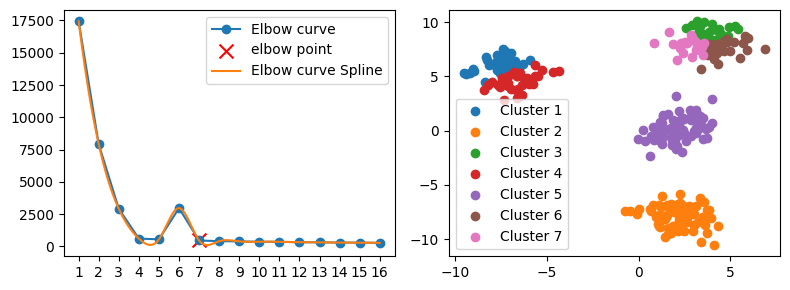

In [92]:
n_clusters_arr = list(range(1, int(math.sqrt(X_train.shape[0]))))
wcss_arr = elbow_curve(X_train, n_clusters_arr=n_clusters_arr)
elbow_point, elbow_spline  = find_elbow_curvature(cluster_range=n_clusters_arr, wcss_values=wcss_arr, return_smooth_elbow_curve = True)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].plot(n_clusters_arr, wcss_arr, marker = 'o', label='Elbow curve')
if elbow_point[0]:
    print(f"Optimal point = {elbow_point}")
    ax[0].scatter(elbow_point[0], elbow_point[1], marker = 'x', s=100, c='r', label='elbow point')
    n_clusters_optimal = int(round(elbow_point[0], 0))
    kmeans_clusterer = myKmeans(n_clusters=n_clusters_optimal)
    final_clusters_train = kmeans_clusterer.fit(X_train)
    for cluster_idx in range(n_clusters_optimal):
        ax[1].scatter(X_train[final_clusters_train[cluster_idx], 0], X_train[final_clusters_train[cluster_idx], 1], label=f'Cluster {1+cluster_idx}')
    
ax[0].plot(elbow_spline[0], elbow_spline[1], label='Elbow curve Spline')

ax[0].set_xticks(ticks=n_clusters_arr, labels=n_clusters_arr)
ax[0].legend();ax[1].legend()

plt.tight_layout()
plt.show()

# Problems with K-Means Clustering
- identifying the best possible `n_clusters` value for your dataset from the elbow curve may not always be intuitive/easy
    - when dimensionality of dataset exceeds 3, the clustering results cannot be visualized.
    - elbow-method will itself not be visualised on production-grade systems and the `wcss` array would be used to programmatically identify the elbow-point.
        - the elbow-point can be identified this way by identifying at what point does the drop in wcss insignificant.
- outliers may not be handled well
    - <font color="red">should outliers be categorised to the *nearest* cluster, or should they be assigned a separate cluster?</font>
- clusters of different orientation may not be captured

## Data sampled from a Uniform random distribution

Elbow-method...:   0%|          | 0/10 [00:00<?, ?it/s]

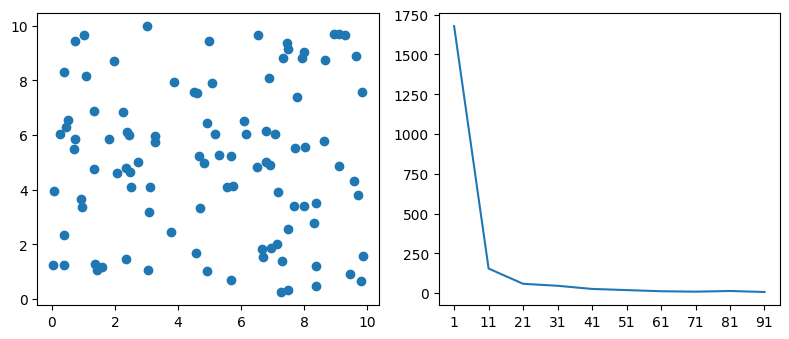

In [ ]:
X = np.random.uniform(low=0, high=10, size=(100, 2)) # random structured data, with no pre-defined obvious/intuitive clusters
wcss_arr = elbow_curve(X, n_clusters_arr=list(range(1,101,10)))

fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))
ax[0].scatter(X[:, 0], X[:, 1])
ax[1].plot(range(1, 1+len(wcss_arr)), wcss_arr)
ax[1].set_xticks(ticks = range(1, 1+len(wcss_arr)), labels = list(range(1,101,10)))

plt.tight_layout()
plt.show()

Iterating through K-Means Clustering...:   0%|          | 0/100 [00:00<?, ?it/s]

Reached convergence at iteration 7, stopping KMeans...


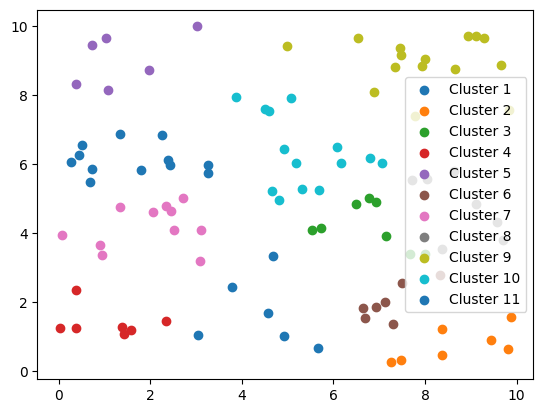

In [66]:
kmeans_clusterer = myKmeans(n_clusters=11)
final_clusters = kmeans_clusterer.fit(X)

for cluster_index in range(kmeans_clusterer.n_clusters):
    plt.scatter(X[final_clusters[cluster_index], 0], X[final_clusters[cluster_index], 1], label=f'Cluster {cluster_index+1}')
plt.legend()
plt.show()

- Although the KMeans algorithm does assign the points to a cluster, the clusters don't make much sense and a smaller `n_clusters` could just as well group up the data.

## Clusters having subclusters: multiple inflection points in the elbow curve
- Lets check another scenario where the elbow curve could have multiple elbows, i.e. points of inflection.
- Also, on performing the elbow-curve analysis on the same dataset, you might get different optimal `n_clusters` due to:
    - the random centroids being selected, which can be fixed by fixing the random_state.
- 

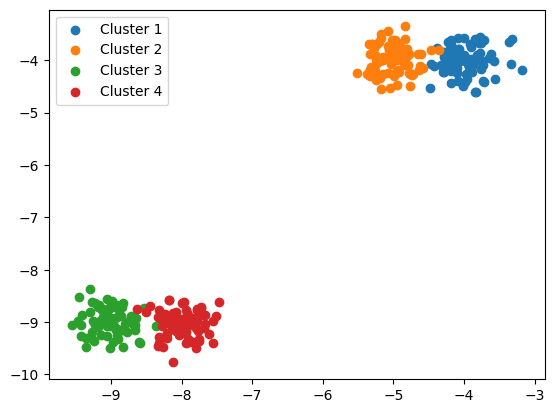

In [112]:
x, y = make_blobs(n_samples=300, cluster_std=0.25, centers = [[-4,-4], [-5, -4], [-9,-9], [-8,-9]])
for cluster_idx in np.unique(y):
    plt.scatter(
        x[y == cluster_idx, 0],
        x[y == cluster_idx, 1],
        label = f'Cluster {1+cluster_idx}'
    )
plt.legend()
plt.show()

Elbow-method...:   0%|          | 0/16 [00:00<?, ?it/s]

Optimal n_clusters = 4, optimal point = [3.975951903807615, 41.370304515908394]


Iterating through K-Means Clustering...:   0%|          | 0/100 [00:00<?, ?it/s]

Reached convergence at iteration 5, stopping KMeans...


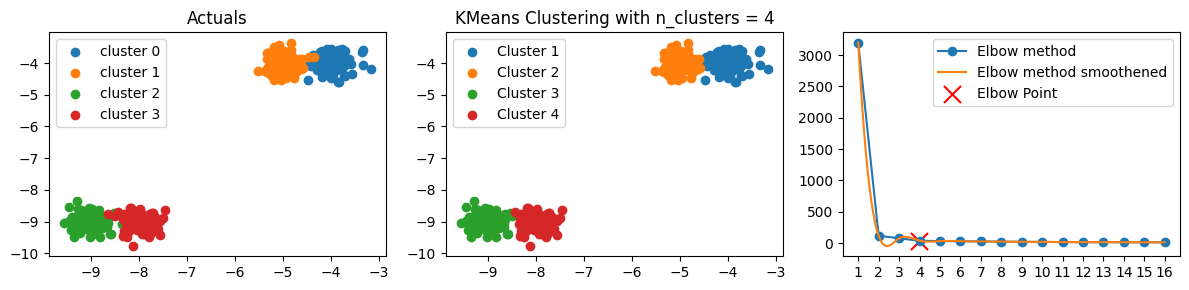

In [115]:
n_clusters_arr = list(range(1,int(math.sqrt(x.shape[0]))))
wcss_arr = elbow_curve(x, n_clusters_arr=n_clusters_arr, seed = 40)
elbow_point, elbow_spline = find_elbow_curvature(cluster_range=n_clusters_arr, wcss_values=wcss_arr, return_smooth_elbow_curve = True)
n_clusters_optimal = int(round(elbow_point[0], 0))
print(f"Optimal n_clusters = {n_clusters_optimal}, optimal point = {elbow_point}")

# perform clustering at n_clusters_optimal found using elbow-curve
kmeans_clusterer = myKmeans(n_clusters=n_clusters_optimal, seed = 40)
final_clusters, distance_track = kmeans_clusterer.fit(x, track_distances=True)

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for cluster_idx in np.unique(y):
    ax[0].scatter(x[y == cluster_idx, 0], x[y == cluster_idx, 1], label=f'cluster {cluster_idx}')

for cluster_idx in range(len(final_clusters)):
    ax[1].scatter(x[final_clusters[cluster_idx], 0], x[final_clusters[cluster_idx], 1], label=f'Cluster {1+cluster_idx}')

ax[0].set_title('Actuals');ax[0].legend()
ax[1].set_title(f'KMeans Clustering with n_clusters = {n_clusters_optimal}');ax[1].legend()

ax[2].plot(n_clusters_arr, wcss_arr, label='Elbow method', marker='o');ax[2].plot(elbow_spline[0], elbow_spline[1], label='Elbow method smoothened')
ax[2].scatter(elbow_point[0], elbow_point[1], marker='x', label='Elbow Point', c='r', s=150)
ax[2].set_xticks(ticks = n_clusters_arr, labels = n_clusters_arr)
ax[2].legend()

plt.tight_layout()
plt.show()

## Clusters of varying densities

## Clusters of varying sizes

## Outliers

## Non-spherical/Non-solid cluster distributions
- refer to this [scikit-learn example](https://scikit-learn.org/1.5/auto_examples/cluster/plot_cluster_comparison.html) to know what all datasets to generate.